In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Storage for results
storage = {
    "adj_matrix": [],
    "laplacian_matrix": [],
    "delta": [],
    "data": [],
    "granger_matrix": [],  # Inferred causality
    "predicted_laplacian": []
}

# Output file
filename = f"../data/statistics_data/statistics_rc.pkl"
f = open(filename, 'wb')

In [2]:
import numpy as np
import networkx as nx

# Load the .npz file
loaded = np.load('../data/generated_data.npz', allow_pickle=True)

# Extract data and structures
x = loaded['x']          # Time series (n, m, time)
A = loaded['A']          # Adjacency (n, n)
L = loaded['L']          # Laplacian (n, n)
delta = loaded['delta']  # Max degree (scalar)
k_in = loaded['k_in']    # In-degrees (n,)
G_adj = loaded['G']      # Adjacency from Graph (n, n)
G = nx.from_numpy_array(G_adj, create_using=nx.DiGraph)  # Reconstruct Graph with directed edges

# Extract parameters as dict
params = loaded['params'].item()  # .item() for dict
n = params['n']
m = params['m']
time = params['time']
transient = params['transient']
beta = params['beta']
mu = params['mu']
sigma = params['sigma']
C = params['C']
gamma = params['gamma']
eta = params['eta']

# Print for verification
print("Loaded data shape:", x.shape)
print("Loaded parameters:", params)
print("In-degrees shape:", k_in.shape)
print("Reconstructed Graph has", G.number_of_edges(), "edges")

Loaded data shape: (1000, 2, 1000)
Loaded parameters: {'n': 1000, 'm': 2, 'time': 1000, 'transient': 14000, 'beta': 4.1, 'mu': 0.001, 'sigma': 0.001, 'C': 0.1, 'gamma': 0.001, 'eta': 0.2}
In-degrees shape: (1000,)
Reconstructed Graph has 1325 edges


In [3]:
def compute_granger(x, max_lag=5):
    u_series = x[:, 0, :]  # u-component (coupled)
    granger_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                data = np.column_stack((u_series[i], u_series[j]))
                try:
                    result = grangercausalitytests(data, maxlag=max_lag, verbose=False)
                    p_values = [result[k+1][0]['ssr_ftest'][1] for k in range(max_lag)]
                    if np.min(p_values) < 0.05:  # Significant causality
                        granger_matrix[i, j] = 1  # j influences i
                except:
                    pass  # Skip if singular
    return granger_matrix

granger_matrix = compute_granger(x)
storage["granger_matrix"].append(granger_matrix)

print("Granger matrix shape:", granger_matrix.shape)

Granger matrix shape: (1000, 1000)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Ridge  # For readout (ridge regression)

class ESN(nn.Module):
    def __init__(self, input_size, reservoir_size, spectral_radius, leaking_rate, input_scale):
        super(ESN, self).__init__()
        self.reservoir_size = reservoir_size
        self.leaking_rate = leaking_rate
        self.W_in = torch.randn(reservoir_size, input_size) * input_scale
        self.W_res = torch.randn(reservoir_size, reservoir_size)
        eigenvalues = torch.linalg.eigvals(self.W_res)
        rho = torch.max(torch.abs(eigenvalues))
        self.W_res = self.W_res * (spectral_radius / rho)
        self.readout = None

    def forward(self, u, r_prev):
        r = (1 - self.leaking_rate) * r_prev + self.leaking_rate * torch.tanh(self.W_in @ u + self.W_res @ r_prev)
        return r

# Train parallel ESNs
# ESN-specific params
esns = []
L_pred = np.zeros((n, n))
train_len = int(0.8 * (time - 1))
warmup = 100  # Increased warmup for stability
reservoir_size = 1000  # High-dim reservoir for chaos
spectral_radius = 0.9  # Ensures echo state property (stability)
leaking_rate = 0.3     # Controls memory fade
input_scale = 1.0      # Input weight scaling
ridge_alpha = 1e-5     # Readout regularization for sparsity-like effect

for i in range(n):
    input_mask = np.ones(n * m)
    input_mask[i*m:(i+1)*m] = 0
    for j in range(n):
        if granger_matrix[i, j] == 0:
            input_mask[j*m:(j+1)*m] *= 0.1
    U = x.reshape(n * m, time) * input_mask[:, None]
    target = x[i].T[1:]  # (time-1, m)
    esn = ESN(input_size=n*m, reservoir_size=reservoir_size, spectral_radius=spectral_radius, 
              leaking_rate=leaking_rate, input_scale=input_scale)
    r = torch.zeros(reservoir_size)
    states = []
    for t in range(time - 1):
        u_t = torch.tensor(U[:, t], dtype=torch.float32)
        r = esn(u_t, r)
        if t >= warmup:
            states.append(r.numpy())
    states = np.array(states)  # (time-1 - warmup, reservoir_size)
    if states.size == 0:
        print(f"Warning: No states collected for node {i}. Check warmup/time.")
        continue
    ridge = Ridge(alpha=ridge_alpha)
    ridge.fit(states[:train_len - warmup], target[warmup:train_len])  # Adjusted slices
    esn.readout = ridge
    contrib = np.abs(esn.W_in.numpy().T @ ridge.coef_.T)
    contrib = contrib.reshape(n, m, m).mean(axis=(1,2))
    L_pred[i] = contrib / np.max(contrib) if np.max(contrib) > 0 else 0
    esns.append(esn)

L_pred = np.diag(np.sum(L_pred, axis=1)) - L_pred
storage["predicted_laplacian"].append(L_pred)

print("Predicted L shape:", L_pred.shape)
print("States shape for node 0:", states.shape if states.size > 0 else "Empty")

/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:252: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/pytho

In [11]:
from scipy import sparse
import pickle

def rmse(L, L_pred, C, delta):
    return np.sqrt(np.mean((L - (C / delta) * L_pred)**2))

# Adjust L_pred for simulation
L_recon = (delta / C) * L_pred  # Scale back

# Simulate with reconstructed
def simulate_with_L(L_used, delta, transient, time, beta, mu, sigma, C, h, gamma, x_noise, n, m):
    def rulkov_map(x):
        x = x.reshape(n, m).T
        return np.asarray([
            beta / (1 + x[0]**2) + x[1],
            x[1] - mu * x[0] - sigma
        ]).T.flatten()

    def net_dynamics(x):
        return rulkov_map(x) - (C / delta) * sparse.kron(L_used, h).dot(x) + x_noise * gamma * np.random.uniform(-1, 1, n * m)

    x0 = np.random.uniform(0.0, 1.0, n * m)
    for _ in range(transient):
        x0 = rulkov_map(x0)
    for _ in range(transient):
        x0 = net_dynamics(x0)
    x_sim = np.zeros((n * m, time))
    x_sim[:, 0] = x0
    for t in range(time - 1):
        x_sim[:, t + 1] = net_dynamics(x_sim[:, t])
    return x_sim.reshape(n, m, time)

h = np.eye(m)
h[1, 1] = 0  # u-coupling
x_noise = np.zeros(n * m)
x_noise[::2] = 1  # Noise on u only

x_reconstructed = simulate_with_L(L_recon, delta, transient, time, beta, mu, sigma, C, h, gamma, x_noise, n, m)

error = rmse(L, L_pred, C, delta)
print("RMSE:", error)

pickle.dump(storage, f)
f.close()

/var/folders/p_/j__hv0j95yv8xknt5_nvt4pw0000gn/T/ipykernel_40944/3141399591.py:15: RuntimeWarning: overflow encountered in square
  beta / (1 + x[0]**2) + x[1],


RMSE: 0.3748475005697199


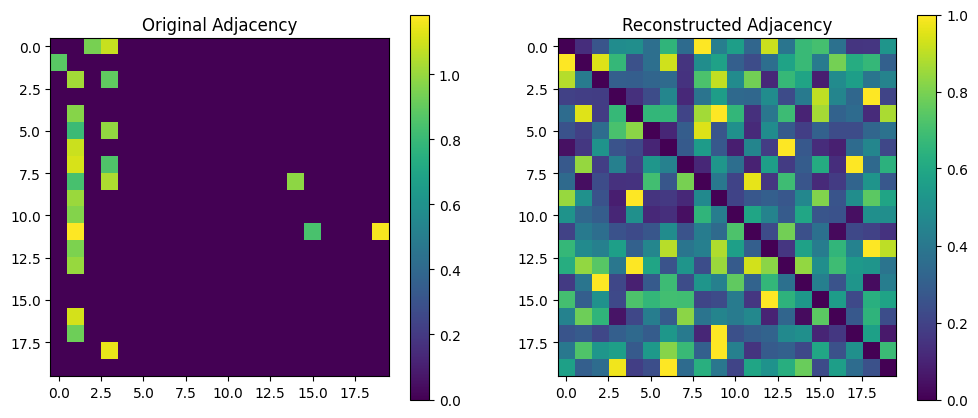

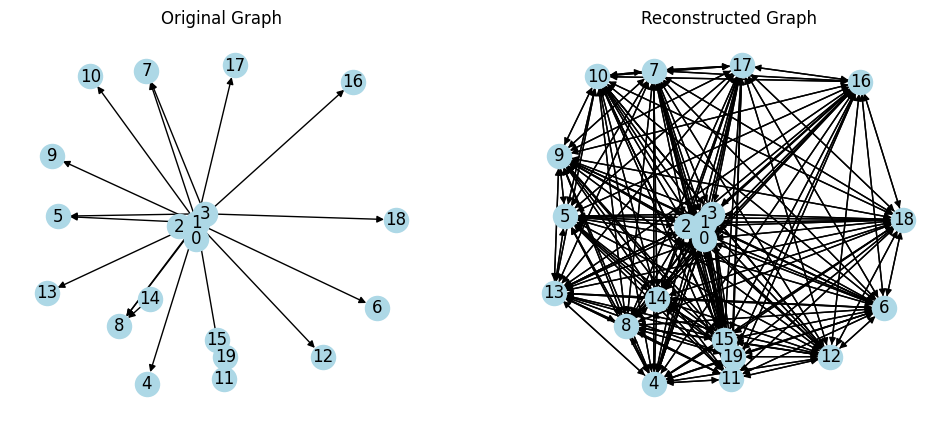

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(A, cmap='viridis')
plt.title('Original Adjacency')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(-L_pred + np.diag(np.diag(L_pred)), cmap='viridis')  # Adjacency-like
plt.title('Reconstructed Adjacency')
plt.colorbar()
plt.show()

# Graphs
G_orig = nx.from_numpy_array(A.T, create_using=nx.DiGraph)
G_recon = nx.from_numpy_array(-L_pred + np.diag(np.diag(L_pred)).T, create_using=nx.DiGraph)
pos = nx.spring_layout(G_orig)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
nx.draw(G_orig, pos, with_labels=True, node_color='lightblue', arrows=True)
plt.title('Original Graph')

plt.subplot(1, 2, 2)
nx.draw(G_recon, pos, with_labels=True, node_color='lightblue', arrows=True)
plt.title('Reconstructed Graph')
plt.show()

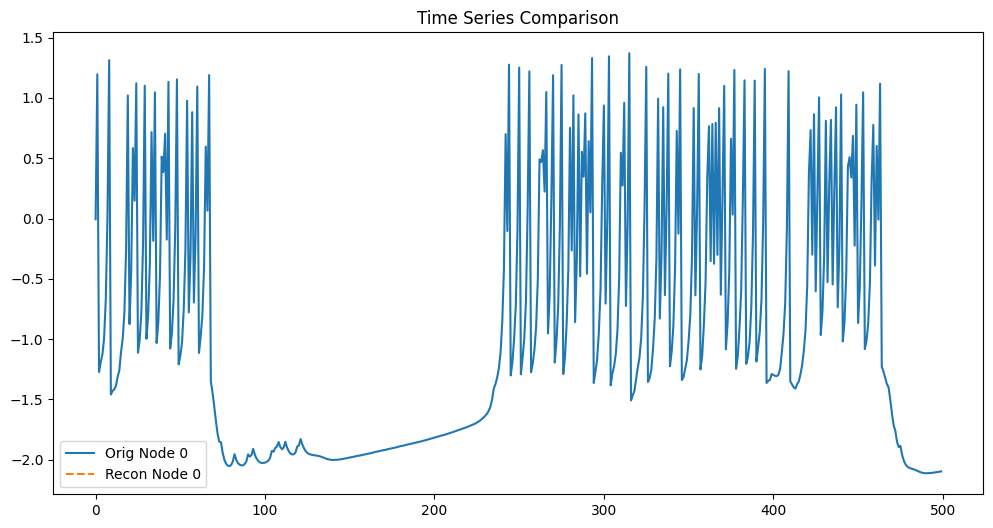

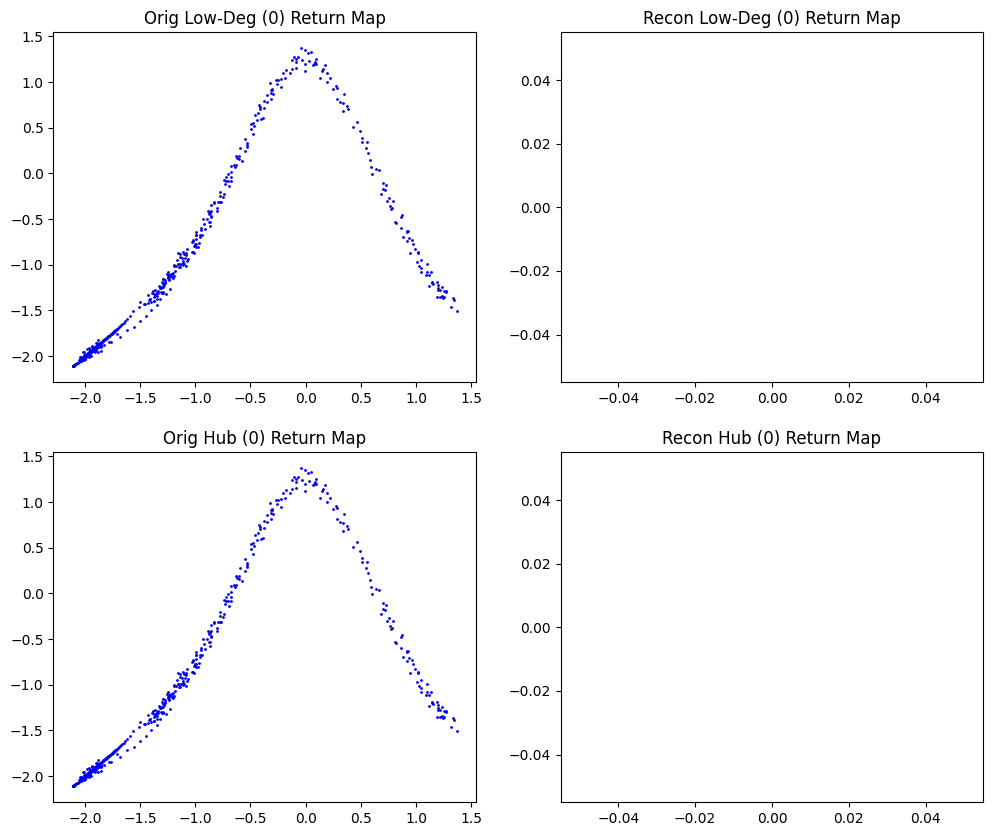

In [14]:
# Identify hub/low-degree from Granger (sum incoming)
s_granger = np.sum(granger_matrix, axis=1)
hub_id = np.argmax(s_granger)
ld_id = np.argmin(s_granger)

# Time series
plt.figure(figsize=(12, 6))
for i in range(1):
    plt.plot(x[i, 0, :], label=f'Orig Node {i}')
    plt.plot(x_reconstructed[i, 0, :], '--', label=f'Recon Node {i}')
plt.title('Time Series Comparison')
plt.legend()
plt.show()

# Return maps
u_orig = x[:, 0, :]
u_recon = x_reconstructed[:, 0, :]
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.scatter(u_orig[ld_id, :-1], u_orig[ld_id, 1:], s=1, c='blue')
plt.title(f'Orig Low-Deg ({ld_id}) Return Map')

plt.subplot(2, 2, 2)
plt.scatter(u_recon[ld_id, :-1], u_recon[ld_id, 1:], s=1, c='red')
plt.title(f'Recon Low-Deg ({ld_id}) Return Map')

plt.subplot(2, 2, 3)
plt.scatter(u_orig[hub_id, :-1], u_orig[hub_id, 1:], s=1, c='blue')
plt.title(f'Orig Hub ({hub_id}) Return Map')

plt.subplot(2, 2, 4)
plt.scatter(u_recon[hub_id, :-1], u_recon[hub_id, 1:], s=1, c='red')
plt.title(f'Recon Hub ({hub_id}) Return Map')
plt.show()